In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [2]:
%matplotlib inline

In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install xgboost

## Random Forest Classifier with water quality parameters

In [6]:
stations_data = pd.read_csv('25stations_data_sur.csv')
rt_data = pd.read_csv('rt_clean.csv')
rawstations_data = pd.read_csv('25station_data.csv')
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('dailystation.csv')

### first model

In [7]:
# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in dailydata.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]

zone_data = dailydata[zone_params].copy()  # Ensure we work with a copy

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    # Check for Zone1_stationID_Sur_D_oxy and rename accordingly
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

zone_data.columns = [rename_column(col) for col in zone_data.columns]

# Ensure unique dates in 'rt' before merging (in case of duplicate reports)
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)

features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']  # Keywords to match in column names

In [8]:
print(zone_data.columns)

Index(['Date', 'TM3 Turbidit', 'TM3 P', 'TM3 N', 'TM3 Temp', 'TM3 D_oxy',
       'TM3 D', 'TM3 Chlo', 'TM4 Turbidit', 'TM4 P', 'TM4 N', 'TM4 Temp',
       'TM4 D_oxy', 'TM4 D', 'TM4 Chlo', 'TM6 Turbidit', 'TM6 P', 'TM6 N',
       'TM6 Temp', 'TM6 D_oxy', 'TM6 D', 'TM6 Chlo', 'TM8 Turbidit', 'TM8 P',
       'TM8 N', 'TM8 Temp', 'TM8 D_oxy', 'TM8 D', 'TM8 Chlo', 'Red Tide'],
      dtype='object')


In [9]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# Define features (X) and target (y)
X = zone_data.loc[:, zone_data.columns.str.contains('|'.join(features_pattern))]
y = zone_data['Red Tide']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data (fit on training data, transform on both train and test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [2, 4, 8],    # Minimum samples required in each leaf
    'max_features': ['sqrt', 'log2'],  # Maximum number of features to consider
    'bootstrap': [True, False],         # Whether to bootstrap samples when building trees
    'class_weight': ['balanced']       # Balanced class weight for imbalanced data
}

# Set up StratifiedKFold for cross-validation in GridSearchCV
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Set up the GridSearchCV to search the hyperparameter space using StratifiedKFold
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Use the best estimator from GridSearchCV
best_rf = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_best = best_rf.predict(X_test_scaled)

# Print the results
print("Test Accuracy of Best Model:", accuracy_score(y_test, y_pred_best))
print("Classification Report of Best Model:\n", classification_report(y_test, y_pred_best, zero_division=0))

# Cross-validation for robustness with Stratified K-Folds
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=stratified_kfold, scoring='accuracy')
print("Cross-Validation Accuracy: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# Compute ROC AUC
y_prob_best = best_rf.predict_proba(X_test_scaled)[:, 1]  # Get probability of positive class
roc_auc = roc_auc_score(y_test, y_prob_best)  # Use probabilities, not class labels
print("ROC AUC:", roc_auc)

# Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob_best)  # Use probabilities, not class labels
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best Hyperparameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Score: 0.9169309295427406
Test Accuracy of Best Model: 0.9271644525881814
Classification Report of Best Model:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1510
           1       0.88      0.89      0.88       673

    accuracy                           0.93      2183
   macro avg       0.91      0.92      0.91      2183
weighted avg       0.93      0.93      0.93      2183

Cross-Validation Accuracy: 0.9169 ± 0.0119
ROC AUC: 0.9781944048099347
Precision-Recall AUC: 0.9578661380736839


Adjusted Classification Report (with threshold 0.3:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      1510
           1       0.82      0.95      0.88       673

    accuracy                           0.92      2183
   macro avg       0.90      0.93      0.91      2183
weighted avg       0.93      0.92      0.92      2183



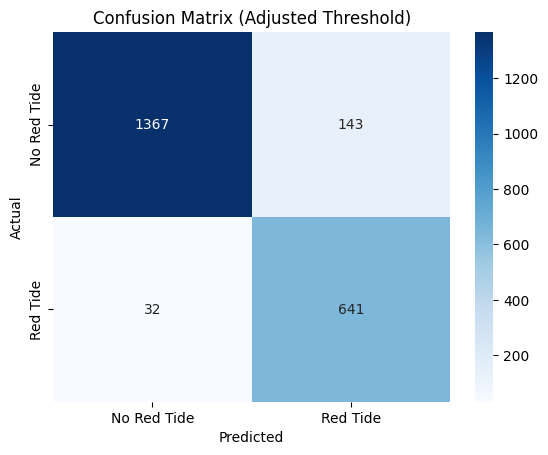

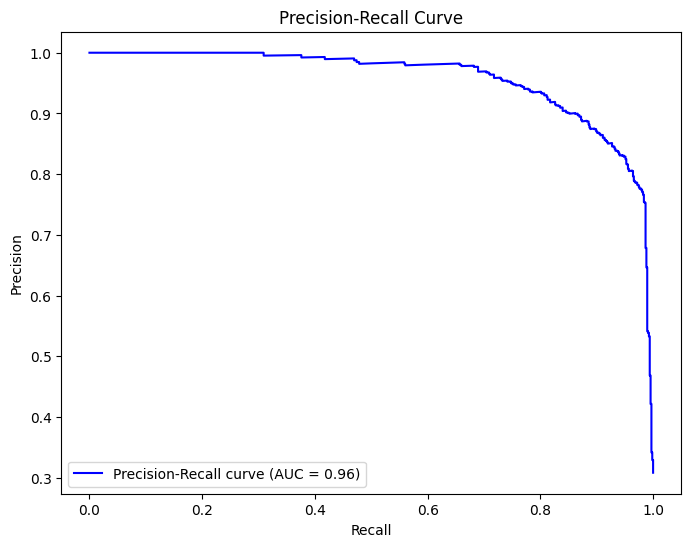

In [10]:
# Adjust the threshold for red tide prediction (e.g., setting threshold to 0.3)
threshold = 0.3  # Experiment with different thresholds
y_pred_adjusted = (y_prob_best >= threshold).astype(int)

# Print adjusted classification report and evaluation metrics
print("Adjusted Classification Report (with threshold 0.3:\n", classification_report(y_test, y_pred_adjusted, zero_division=0))

# Confusion Matrix for the adjusted threshold
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Red Tide', 'Red Tide'], yticklabels=['No Red Tide', 'Red Tide'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

Top 10 Features by Importance:
         Feature  Importance
20         TM8 N    0.054254
12  TM6 Turbidit    0.051991
14         TM6 N    0.048017
8          TM4 N    0.047229
9       TM4 Temp    0.044579
3       TM3 Temp    0.044016
23      TM8 Chlo    0.043691
21      TM8 Temp    0.043281
16     TM6 D_oxy    0.042922
18  TM8 Turbidit    0.042895


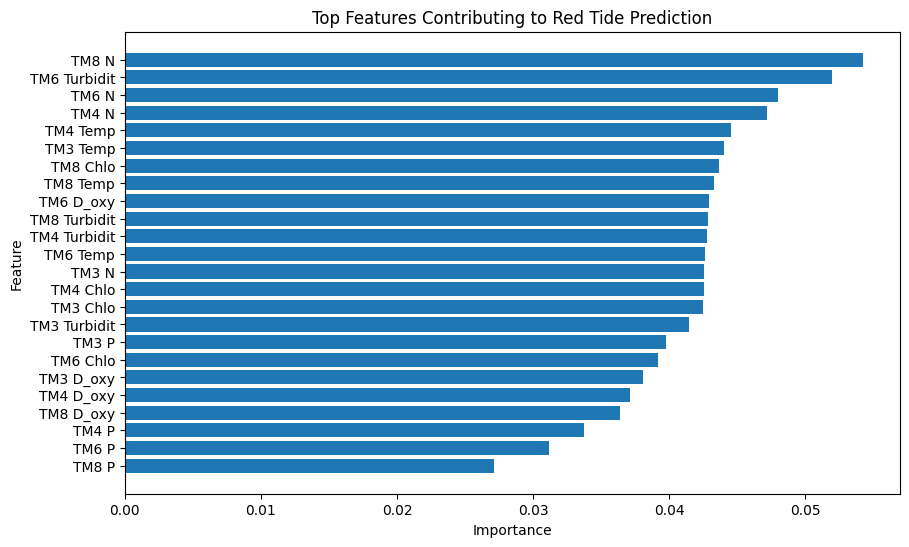

In [11]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top features
print("Top 10 Features by Importance:")
print(feature_importances.head(10))

# Plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top Features Contributing to Red Tide Prediction")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


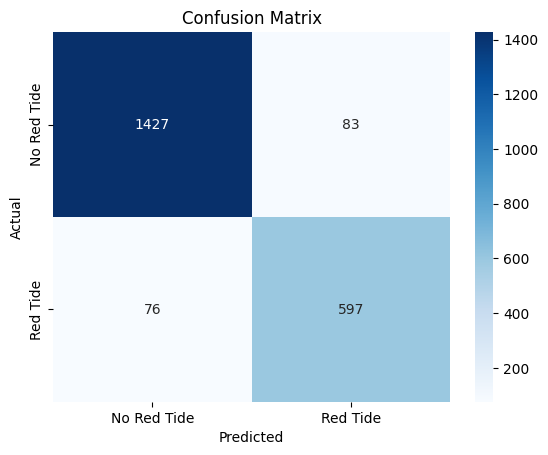

In [12]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

# Ensure the correct predicted labels are used
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot Confusion Matrix
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Red Tide', 'Red Tide'], 
           yticklabels=['No Red Tide', 'Red Tide'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Validation

In [13]:
# Load the validation data
val_data = pd.read_csv(r"C:\Users\User\FYP(DESKTOP)\val set\zone1_final.csv")
val_rt = pd.read_csv(r"C:\Users\User\FYP(DESKTOP)\val set\red_tide_val.csv")

# Convert 'Date' columns to datetime format
val_data['Date'] = pd.to_datetime(val_data['Date'], errors='coerce')
val_rt['Date'] = pd.to_datetime(val_rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in val_data.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]

val_data = val_data[zone_params].copy()  # Ensure we work with a copy

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    # Check for Zone1_stationID_Sur_D_oxy and rename accordingly
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

val_data.columns = [rename_column(col) for col in val_data.columns]
# Merge red tide occurrences (for target column)
val_data = val_data.merge(val_rt[['Date', 'Red Tide']], on='Date', how='left')
val_data['Red Tide'] = val_data['Red Tide'].fillna(0).astype(int)
features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']  # Keywords to match in column names
print(val_data.columns)

Index(['Date', 'TM3 D_oxy', 'TM4 D_oxy', 'TM6 D_oxy', 'TM8 D_oxy', 'TM3 D',
       'TM4 D', 'TM6 D', 'TM8 D', 'TM3 Chlo', 'TM4 Chlo', 'TM6 Chlo',
       'TM8 Chlo', 'TM3 Turbidit', 'TM4 Turbidit', 'TM6 Turbidit',
       'TM8 Turbidit', 'TM3 P', 'TM4 P', 'TM6 P', 'TM8 P', 'TM3 N', 'TM4 N',
       'TM6 N', 'TM8 N', 'TM3 Temp', 'TM4 Temp', 'TM6 Temp', 'TM8 Temp',
       'Red Tide'],
      dtype='object')


In [14]:
# Select the same features as in the training set
X_val = val_data.loc[:, val_data.columns.str.contains('|'.join(features_pattern))]

X_val = X_val.reindex(columns=X.columns)

# Scale the validation data (using the same scaler fitted on the training data)
X_val_scaled = scaler.transform(X_val)

# Predict red tide occurrences
y_val_pred = best_rf.predict(X_val_scaled)

# Add predictions to the validation data
val_data['Predicted Red Tide'] = y_val_pred

# Extract the week number (you can use other aggregations if needed)
val_data['Week'] = val_data['Date'].dt.isocalendar().week

# Group by week and calculate the percentage of weeks with predicted red tide occurrences
weekly_predictions = val_data.groupby('Week')['Predicted Red Tide'].mean()

# Display the results (percentage of predicted red tide occurrences per week)
print(weekly_predictions)

Week
2     0.0
3     0.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     0.0
10    0.0
11    0.0
13    0.0
16    0.5
17    0.0
18    0.0
19    0.0
20    0.5
22    0.0
23    0.0
24    0.0
25    0.0
28    0.0
29    0.0
30    0.0
32    0.0
33    0.0
35    0.0
37    0.0
38    0.5
42    0.0
43    0.0
45    0.0
46    0.0
47    0.0
50    0.0
Name: Predicted Red Tide, dtype: float64


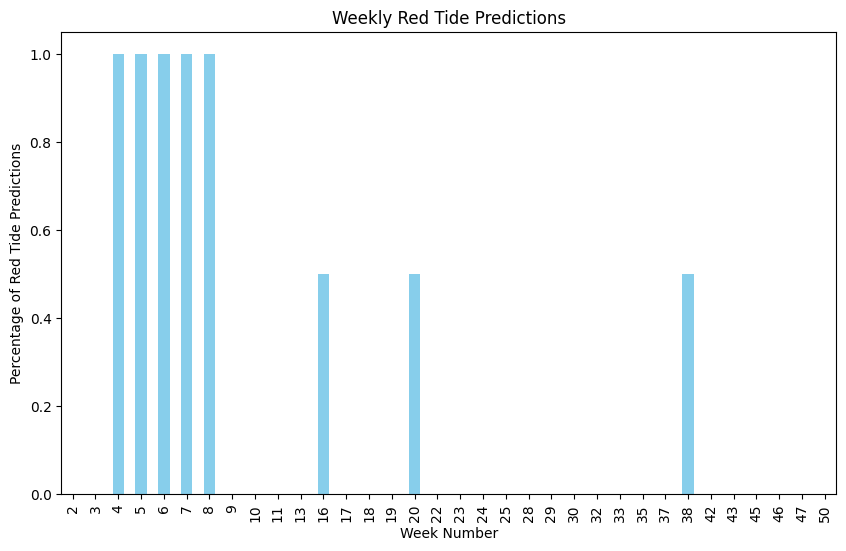

In [15]:
# Plot weekly predictions
plt.figure(figsize=(10, 6))
weekly_predictions.plot(kind='bar', color='skyblue')
plt.xlabel("Week Number")
plt.ylabel("Percentage of Red Tide Predictions")
plt.title("Weekly Red Tide Predictions")
plt.show()

Accuracy on Validation Set: 0.7657342657342657
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1185
           1       0.28      0.22      0.25       245

    accuracy                           0.77      1430
   macro avg       0.56      0.55      0.55      1430
weighted avg       0.75      0.77      0.76      1430



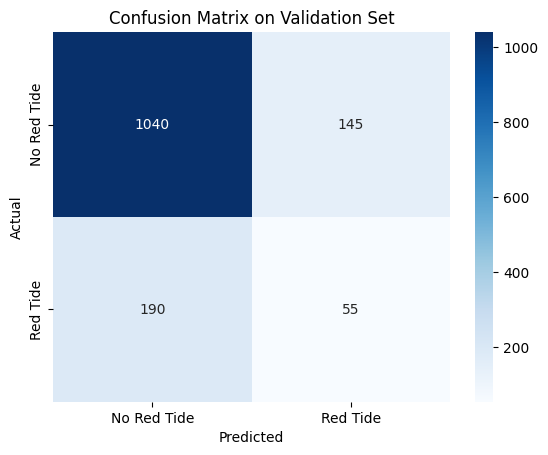

In [16]:
# Load validation set
val_data = pd.read_csv(r'C:\Users\User\FYP(DESKTOP)\val set\zone1_daily.csv')
val_rt = pd.read_csv(r'C:\Users\User\FYP(DESKTOP)\val set\red_tide_val.csv')

# Convert 'Date' columns to datetime format (if necessary)
val_data['Date'] = pd.to_datetime(val_data['Date'], errors='coerce')
val_rt['Date'] = pd.to_datetime(val_rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in val_data.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]

val_data = val_data[zone_params].copy()  # Ensure we work with a copy

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    # Check for Zone1_stationID_Sur_D_oxy and rename accordingly
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

val_data.columns = [rename_column(col) for col in val_data.columns]

# Merge red tide occurrences (for target column)
val_data = val_data.merge(val_rt[['Date', 'Red Tide']], on='Date', how='left')
val_data['Red Tide'] = val_data['Red Tide'].fillna(0).astype(int)

# Define features (X) for the validation set (same as during training)
features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']  # Keywords to match in column names
X_val = val_data.loc[:, val_data.columns.str.contains('|'.join(features_pattern))]

# Ensure that X_val columns match the training set features order
X_val = X_val.reindex(columns=X.columns)

# Scale the validation data using the same scaler fitted on the training set
X_val_scaled = scaler.transform(X_val)

# Make predictions on the validation set using the best model from GridSearchCV
y_val_pred = best_rf.predict(X_val_scaled)

# Compare predictions with the ground truth (Red Tide occurrences in the validation set)
y_val_true = val_data['Red Tide']

# Print evaluation results
print("Accuracy on Validation Set:", accuracy_score(y_val_true, y_val_pred))
print("Classification Report on Validation Set:\n", classification_report(y_val_true, y_val_pred, zero_division=0))

# Confusion Matrix for the validation set
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

conf_matrix_val = confusion_matrix(y_val_true, y_val_pred)
sb.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['No Red Tide', 'Red Tide'], yticklabels=['No Red Tide', 'Red Tide'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()


## XG boost for wq

In [17]:
# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in dailydata.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]

zone_data = dailydata[zone_params].copy()  # Ensure we work with a copy

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    # Check for Zone1_stationID_Sur_D_oxy and rename accordingly
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

zone_data.columns = [rename_column(col) for col in zone_data.columns]

# Ensure unique dates in 'rt' before merging (in case of duplicate reports)
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)

features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']  # Keywords to match in column names

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 3.134424816889272, 'subsample': 0.7}
Accuracy: 0.9196
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       990
           1       0.86      0.90      0.88       465

    accuracy                           0.92      1455
   macro avg       0.90      0.91      0.91      1455
weighted avg       0.92      0.92      0.92      1455



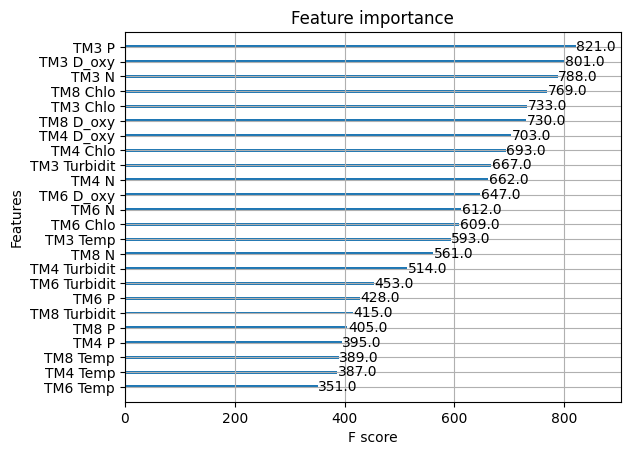

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Filter columns based on the features pattern
feature_columns = [col for col in zone_data.columns if any(keyword in col for keyword in features_pattern)]

# Prepare the data: features (X) and target (y)
X = zone_data[feature_columns]
y = zone_data['Red Tide']  # Target variable

# Handle missing values (if any) by filling with the mean for the features
X = X.fillna(X.mean())

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adjust the class weight (use scale_pos_weight for handling class imbalance)
scale_pos_weight = len(y) / sum(y)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7, 10],  # Depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'subsample': [0.7, 0.8, 0.9],  # Fraction of samples used for each tree
    'colsample_bytree': [0.7, 0.8, 0.9],  # Fraction of features used for each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) in a child
    'scale_pos_weight': [scale_pos_weight]  # Handling class imbalance
}

# Initialize the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',  # Evaluation metric
    use_label_encoder=False  # Disable label encoder warning
)

# Use Stratified K-Folds Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform GridSearchCV for hyperparameter tuning with Stratified K-Folds
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=skf,  # Use Stratified K-Folds
    scoring='accuracy',  # Evaluation metric
    n_jobs=-1,  # Use all processors
    verbose=1  # Display progress
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Train the model with the best parameters
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
print(classification_report(y_test, y_pred))

#plot the feature importance
xgb.plot_importance(best_model)
plt.show()


### Second model

In [20]:
rt = pd.read_csv('red_tide_occurrences.csv', parse_dates=['Date'], dayfirst=True)
stations_data = pd.read_csv('25stations_data_sur.csv', parse_dates=['Date'], dayfirst=True)
dailydata = pd.read_csv('c.csv', parse_dates=['Date'], dayfirst=True)

In [21]:
# Convert 'Date' columns to datetime objects
rt['Date'] = pd.to_datetime(rt['Date'])
dailydata['Date'] = pd.to_datetime(stations_data['Date'])

# Select data for Zone 1 (adapt column names as needed)
zone1_cols = [col for col in stations_data.columns if 'Zone1' in col and 'Sur' in col]
zone1_data = stations_data[['Date'] + zone1_cols]

merged_df = pd.merge_asof(rt.sort_values('Date'), 
                          zone1_data.sort_values('Date'), 
                          on='Date', 
                          direction='backward')


# Define Features (X) and Target Variable (y)
X = merged_df.drop(columns=['Date', 'Red Tide'])
y = merged_df['Red Tide']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print(classification_report(y_test, y_pred))


Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.69      0.96      0.81       995
           1       0.54      0.10      0.17       470

    accuracy                           0.68      1465
   macro avg       0.62      0.53      0.49      1465
weighted avg       0.64      0.68      0.60      1465



In [23]:
# Define the RandomForestClassifier model
rfc = RandomForestClassifier(random_state=42)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]             # Whether bootstrap samples are used
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters after GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [24]:
# Use the best model found by GridSearchCV
best_rfc = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rfc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Accuracy: {accuracy:.2f}")

# Classification Report
print(classification_report(y_test, y_pred))

Optimized Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       995
           1       0.53      0.10      0.17       470

    accuracy                           0.68      1465
   macro avg       0.61      0.53      0.49      1465
weighted avg       0.64      0.68      0.60      1465



## RNN time series model

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [26]:
rt = pd.read_csv('red_tide_occurrences.csv', parse_dates=['Date'], dayfirst=True)
stations_data = pd.read_csv('25stations_data_sur.csv', parse_dates=['Date'], dayfirst=True)

In [27]:
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata= pd.read_csv('dailystation.csv')

In [28]:
dailydata['Date'] = pd.to_datetime(stations_data['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

In [29]:
# Select only the columns for Zone1 and the specific parameters
zone_cols = ['Date'] + [
    col for col in dailydata.columns
    if 'Zone1' in col and re.search(r'(Sur_N\$?|Sur_Chlo_a|Sur_P\$?|Sur_Temp|Sur_Salinity)(?=$|_)', col) and 'Zone10' not in col
]

zone_data = dailydata[zone_cols]

zone_data = zone_data.copy()  # Make sure it's a copy of the original data

In [30]:
data = pd.merge(rt, zone_data, on='Date', how='inner')
data.ffill(inplace=True)  # Forward fill missing values
data.head()

,Date,Red Tide,Zone1_TM3_Sur_P,Zone1_TM3_Sur_N,Zone1_TM3_Sur_Temp,Zone1_TM3_Sur_Salinity,Zone1_TM3_Sur_Chlo_a,Zone1_TM4_Sur_P,Zone1_TM4_Sur_N,Zone1_TM4_Sur_Temp,...,Zone1_TM6_Sur_P,Zone1_TM6_Sur_N,Zone1_TM6_Sur_Temp,Zone1_TM6_Sur_Salinity,Zone1_TM6_Sur_Chlo_a,Zone1_TM8_Sur_P,Zone1_TM8_Sur_N,Zone1_TM8_Sur_Temp,Zone1_TM8_Sur_Salinity,Zone1_TM8_Sur_Chlo_a
0,1997-01-01,1,0.199524,0.969524,19.085714,31.114286,11.219048,0.165714,0.900476,18.609524,...,0.141905,0.869524,18.580952,32.014286,4.761905,0.097143,0.627143,18.528571,32.114286,1.328571
1,1997-01-02,1,0.199524,0.969524,19.085714,31.114286,11.219048,0.165714,0.900476,18.609524,...,0.141905,0.869524,18.580952,32.014286,4.761905,0.097143,0.627143,18.528571,32.114286,1.328571
2,1997-01-03,1,0.199524,0.969524,19.085714,31.114286,11.219048,0.165714,0.900476,18.609524,...,0.141905,0.869524,18.580952,32.014286,4.761905,0.097143,0.627143,18.528571,32.114286,1.328571
3,1997-01-04,1,0.199524,0.969524,19.085714,31.114286,11.219048,0.165714,0.900476,18.609524,...,0.141905,0.869524,18.580952,32.014286,4.761905,0.097143,0.627143,18.528571,32.114286,1.328571
4,1997-01-05,1,0.199524,0.969524,19.085714,31.114286,11.219048,0.165714,0.900476,18.609524,...,0.141905,0.869524,18.580952,32.014286,4.761905,0.097143,0.627143,18.528571,32.114286,1.328571


In [31]:
scaler = StandardScaler()
features = data.drop(columns=['Date', 'Red Tide'])
features_scaled = scaler.fit_transform(features)

# Convert target variable
target = data['Red Tide'].values

In [32]:
def create_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])
    return np.array(X_seq), np.array(y_seq)

n_steps = 12  # Using past 12 months of data
X, y = create_sequences(features_scaled, target, n_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [33]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5913 - loss: 0.6846 - val_accuracy: 0.5435 - val_loss: 0.7180
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7379 - loss: 0.6221 - val_accuracy: 0.5435 - val_loss: 0.8607
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7241 - loss: 0.5753 - val_accuracy: 0.5435 - val_loss: 1.8977
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7205 - loss: 0.5857 - val_accuracy: 0.5435 - val_loss: 5.0342
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7490 - loss: 0.5257 - val_accuracy: 0.5435 - val_loss: 5.3661
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7063 - loss: 0.5723 - val_accuracy: 0.5435 - val_loss: 4.1041
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6227 - loss: 0.6883
Test Accuracy: 0.54


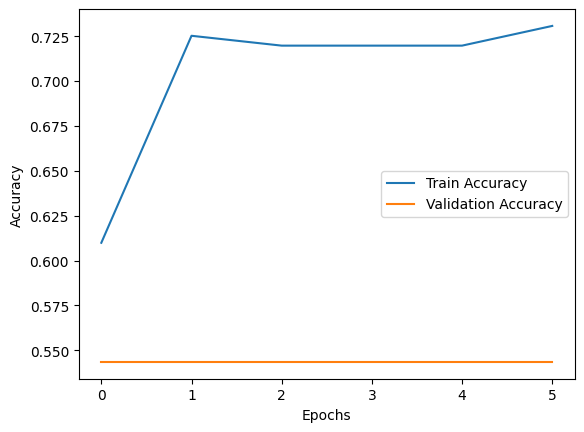

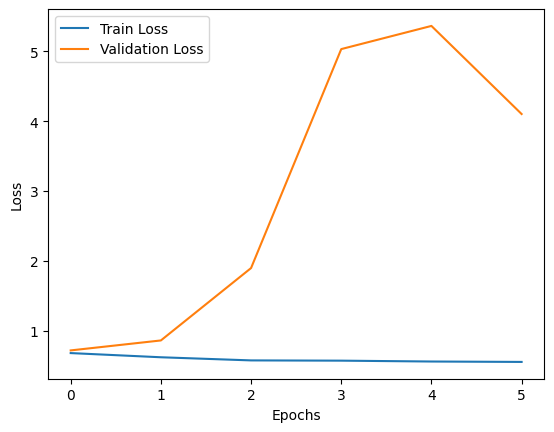

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## RNN Model 2

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [37]:
# Read both CSV files
rt = pd.read_csv('red_tide_occurrences.csv')
stations_data = pd.read_csv('dailystation.csv')

# Convert the 'Date' columns in both DataFrames to datetime
rt['Date'] = pd.to_datetime(rt['Date'], errors='coerce')
stations_data['Date'] = pd.to_datetime(stations_data['Date'], errors='coerce')


In [38]:
# Identify all Zone columns
zone_columns = [
    col for col in stations_data.columns
    if 'Zone1' in col and 'Zone10' not in col
]
stations_zone = stations_data[['Date'] + zone_columns]
# Extract parameter names (removing Zone and Station info)
parameter = set(col.split("_Sur_")[-1] for col in zone_columns)
print(f"Unique Parameters: {parameter}")
print(stations_zone.shape)


Unique Parameters: {'D_oxy_pe', 'pigment', 'VSSolids', 'D_oxy', 'SD_depth', 'F_coli', 'N2O3', 'Kje_N', 'Salinity', 'UI_NH3', 'Turbidit', 'Inorg_N', 'Silica', 'SSolids', 'P2O4', 'N', 'Chlo_a', 'Temp', 'pH', 'E_coli', 'N2H3', 'P', 'N2O2', 'Oxy_dema'}
(7275, 97)


In [39]:
# Group by Date and compute the mean of each parameter across all Zone1 stations
zone_aggregated = stations_zone.copy()
for param in parameter:
    param_columns = [col for col in zone_columns if col.endswith(param)]
    zone_aggregated[param] = stations_zone[param_columns].mean(axis=1)

# Keep only Date and the 24 aggregated parameters
zone_aggregated = zone_aggregated[['Date'] + list(parameter)]

# Merge with red tide data
data = pd.merge(rt, zone_aggregated, on="Date", how="left")

# Forward-fill missing values
data.ffill(inplace=True)

In [40]:
target_col = 'Red Tide'  

# Sort data by Date to maintain time order
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

# Fill any remaining missing values
data.ffill(inplace=True)
data.bfill(inplace=True)

# Define features (all aggregated parameters) and target
# Exclude the Date column and target column from features
feature_cols = [col for col in data.columns if col not in ['Date', target_col]]
X = data[feature_cols].values
y = data[target_col].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a function to create sequences for LSTM training.
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Set the number of time steps (window length)
TIME_STEPS = 7
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=TIME_STEPS)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification, change accordingly for regression
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=1)

Epoch 1/50


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6983 - loss: 0.6230 - val_accuracy: 0.6499 - val_loss: 0.6543
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7098 - loss: 0.5850 - val_accuracy: 0.6499 - val_loss: 0.6652
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7040 - loss: 0.5897 - val_accuracy: 0.6499 - val_loss: 0.6713
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7061 - loss: 0.5868 - val_accuracy: 0.6499 - val_loss: 0.6863
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7098 - loss: 0.5855 - val_accuracy: 0.6499 - val_loss: 0.6785
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7058 - loss: 0.5866 - val_accuracy: 0.6499 - val_loss: 0.6819
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7049 - loss: 0.5828 - val_accuracy: 0.6499 - val_loss: 0.6707
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7108 - loss: 0.5771 - val_accuracy: 0.6499 - val_

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7189 - loss: 0.6611
Test Loss: 0.8550, Test Accuracy: 0.6168


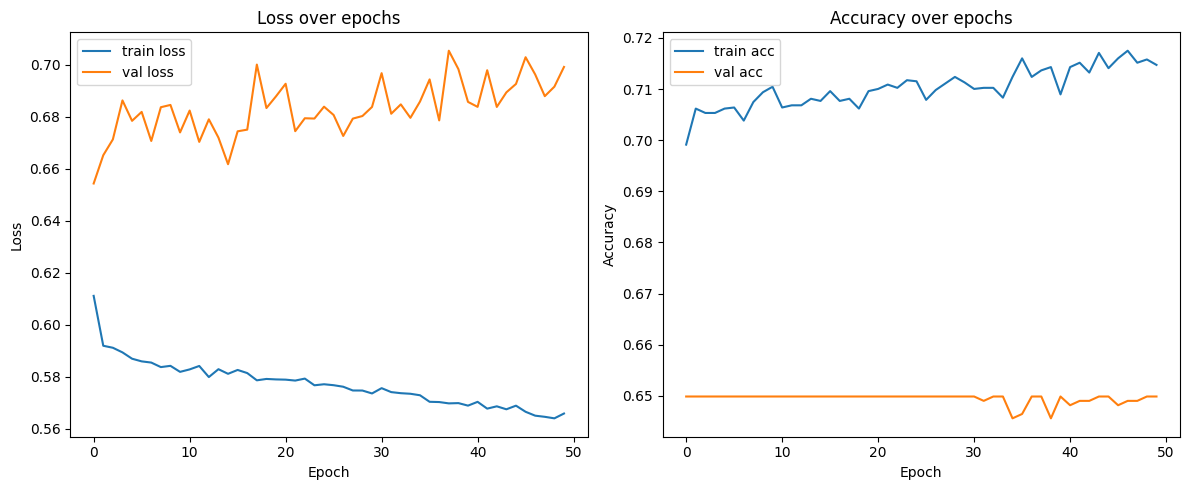

In [42]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## RNN-LSTM Model 3

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.models import save_model
from keras.models import load_model
# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in dailydata.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]

zone_data = dailydata[zone_params].copy()  # Ensure we work with a copy

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    # Check for Zone1_stationID_Sur_D_oxy and rename accordingly
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

zone_data.columns = [rename_column(col) for col in zone_data.columns]

# Ensure unique dates in 'rt' before merging (in case of duplicate reports)
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)

features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']  # Keywords to match in column names


In [7]:
!pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Function to create time-series sequences
def create_dataset(X, y, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])  
        ys.append(y[i + time_steps])  

    return np.array(Xs), np.array(ys)

# Filter relevant features
X = zone_data.loc[:, [col for col in zone_data.columns if any(re.search(pattern, col, re.IGNORECASE) for pattern in features_pattern)]]
y = zone_data['Red Tide']

# Standardize before sequence creation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create time-series sequences
time_steps = 14  
X_seq, y_seq = create_dataset(X_scaled, y, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_resampled = X_train_resampled.reshape(-1, time_steps, X_train.shape[2])  # Reshape back

# Compute class weights (FIXED: Convert classes to NumPy array)
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_resampled)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# Build a BiLSTM model with dropout
model = Sequential([
    Bidirectional(LSTM(256, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(128, activation='tanh')),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile with AdamW optimizer and weighted loss
model.compile(optimizer=AdamW(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)

# Train model with resampled data
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), class_weight=class_weights, 
                    callbacks=[early_stop, reduce_lr])

# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype(int)  

# Evaluation metrics
print(classification_report(y_test, y_pred_classes))
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))

# Save the improved model
model.save('red_tide_bilstm_model.keras')


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Epoch 1/100


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6197 - loss: 0.6382 - val_accuracy: 0.6538 - val_loss: 0.6043 - learning_rate: 5.0000e-04
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7045 - loss: 0.5440 - val_accuracy: 0.7247 - val_loss: 0.4951 - learning_rate: 5.0000e-04
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7362 - loss: 0.4971 - val_accuracy: 0.7605 - val_loss: 0.4714 - learning_rate: 5.0000e-04
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7872 - loss: 0.4413 - val_accuracy: 0.7818 - val_loss: 0.4283 - learning_rate: 5.0000e-04
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7928 - loss: 0.4311 - val_accuracy: 0.7667 - val_loss: 0.4464 - learning_rate: 5.0000e-04
Epoch 6/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.8136 - loss: 0.3890 - val_accuracy: 0.7956 - val_loss: 0.4212 - learning_rate: 5.0000e-04
Epoch 7/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accurac

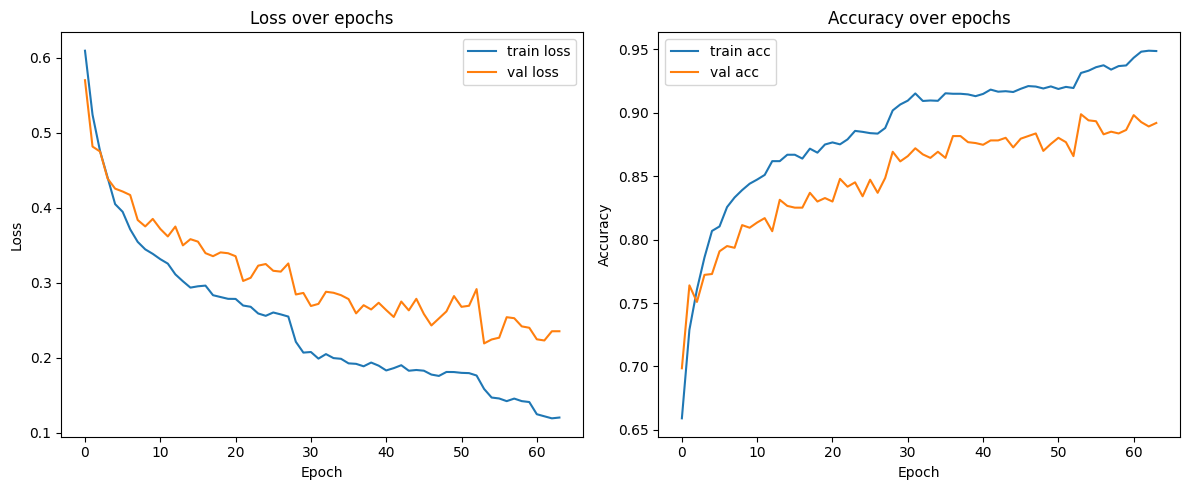

In [9]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import clone_model

# Function to create time-series sequences (same as before)
def create_dataset(X, y, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])  
        ys.append(y[i + time_steps])  

    return np.array(Xs), np.array(ys)

# Filter relevant features (same as before)
X = zone_data.loc[:, [col for col in zone_data.columns if any(re.search(pattern, col, re.IGNORECASE) for pattern in features_pattern)]]
y = zone_data['Red Tide']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create time-series sequences
time_steps = 14  
X_seq, y_seq = create_dataset(X_scaled, y, time_steps)

# Apply Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store the evaluation metrics across folds
accuracies = []
auc_scores = []
confusion_matrices = []

# Stratified K-Fold Cross-Validation loop
for train_index, val_index in kf.split(X_seq, y_seq):
    X_train, X_val = X_seq[train_index], X_seq[val_index]
    y_train, y_val = y_seq[train_index], y_seq[val_index]
    
    # Apply SMOTE for class balancing
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
    X_train_resampled = X_train_resampled.reshape(-1, time_steps, X_train.shape[2])  # Reshape back
    
    # Compute class weights (same as before)
    class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_resampled)
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    
    # Clone the model to ensure a fresh model for each fold
    model = Sequential([
        Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Bidirectional(LSTM(64, activation='tanh')),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model (same as before)
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Callbacks for early stopping and learning rate reduction
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, 
              validation_data=(X_val, y_val), class_weight=class_weights, 
              callbacks=[early_stop, reduce_lr])
    
    # Evaluate the model on the validation set
    y_pred_prob = model.predict(X_val)
    y_pred_classes = (y_pred_prob > 0.5).astype(int)
    
    # Collect metrics for this fold
    accuracies.append(accuracy_score(y_val, y_pred_classes))
    auc_scores.append(roc_auc_score(y_val, y_pred_prob))
    confusion_matrices.append(confusion_matrix(y_val, y_pred_classes))

# Average the results across folds
print("Average Accuracy: ", np.mean(accuracies))
print("Average AUC Score: ", np.mean(auc_scores))
print("Average Confusion Matrix:\n", np.mean(confusion_matrices, axis=0))


Epoch 1/100


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6372 - loss: 0.6282 - val_accuracy: 0.7130 - val_loss: 0.5397 - learning_rate: 5.0000e-04
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7126 - loss: 0.5394 - val_accuracy: 0.7006 - val_loss: 0.5458 - learning_rate: 5.0000e-04
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7542 - loss: 0.4879 - val_accuracy: 0.7474 - val_loss: 0.4724 - learning_rate: 5.0000e-04
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7897 - loss: 0.4370 - val_accuracy: 0.7674 - val_loss: 0.4638 - learning_rate: 5.0000e-04
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8030 - loss: 0.4102 - val_accuracy: 0.7770 - val_loss: 0.4535 - learning_rate: 5.0000e-04
Epoch 6/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8239 - loss: 0.3815 - val_accuracy: 0.7887 - val_loss: 0.4541 - learning_rate: 5.0000e-04
Epoch 7/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy

C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6356 - loss: 0.6371 - val_accuracy: 0.6949 - val_loss: 0.5553 - learning_rate: 5.0000e-04
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7252 - loss: 0.5267 - val_accuracy: 0.7225 - val_loss: 0.5030 - learning_rate: 5.0000e-04
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7522 - loss: 0.4829 - val_accuracy: 0.7672 - val_loss: 0.4622 - learning_rate: 5.0000e-04
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7779 - loss: 0.4417 - val_accuracy: 0.7638 - val_loss: 0.4594 - learning_rate: 5.0000e-04
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7972 - loss: 0.4151 - val_accuracy: 0.7955 - val_loss: 0.4053 - learning_rate: 5.0000e-04
Epoch 6/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8107 - loss: 0.3968 - val_accuracy: 0.7782 - val_loss: 0.4113 - learning_rate: 5.0000e-04
Epoch 7/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy

C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6590 - loss: 0.6248 - val_accuracy: 0.7018 - val_loss: 0.5406 - learning_rate: 5.0000e-04
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7246 - loss: 0.5254 - val_accuracy: 0.7307 - val_loss: 0.5138 - learning_rate: 5.0000e-04
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7584 - loss: 0.4863 - val_accuracy: 0.7362 - val_loss: 0.4968 - learning_rate: 5.0000e-04
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7819 - loss: 0.4501 - val_accuracy: 0.7610 - val_loss: 0.4615 - learning_rate: 5.0000e-04
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7978 - loss: 0.4206 - val_accuracy: 0.7837 - val_loss: 0.4377 - learning_rate: 5.0000e-04
Epoch 6/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8074 - loss: 0.4088 - val_accuracy: 0.8120 - val_loss: 0.4135 - learning_rate: 5.0000e-04
Epoch 7/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy

C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6282 - loss: 0.6310 - val_accuracy: 0.6894 - val_loss: 0.5437 - learning_rate: 5.0000e-04
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7118 - loss: 0.5437 - val_accuracy: 0.7321 - val_loss: 0.5064 - learning_rate: 5.0000e-04
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7674 - loss: 0.4800 - val_accuracy: 0.7376 - val_loss: 0.4826 - learning_rate: 5.0000e-04
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7894 - loss: 0.4381 - val_accuracy: 0.7858 - val_loss: 0.4327 - learning_rate: 5.0000e-04
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8134 - loss: 0.3979 - val_accuracy: 0.8010 - val_loss: 0.4328 - learning_rate: 5.0000e-04
Epoch 6/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8132 - loss: 0.3921 - val_accuracy: 0.8037 - val_loss: 0.4013 - learning_rate: 5.0000e-04
Epoch 7/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy

C:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6290 - loss: 0.6362 - val_accuracy: 0.6715 - val_loss: 0.5562 - learning_rate: 5.0000e-04
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7231 - loss: 0.5317 - val_accuracy: 0.7018 - val_loss: 0.5419 - learning_rate: 5.0000e-04
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7613 - loss: 0.4889 - val_accuracy: 0.7479 - val_loss: 0.4739 - learning_rate: 5.0000e-04
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7830 - loss: 0.4375 - val_accuracy: 0.7528 - val_loss: 0.4680 - learning_rate: 5.0000e-04
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8111 - loss: 0.3894 - val_accuracy: 0.7514 - val_loss: 0.4640 - learning_rate: 5.0000e-04
Epoch 6/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8163 - loss: 0.3855 - val_accuracy: 0.7652 - val_loss: 0.4494 - learning_rate: 5.0000e-04
Epoch 7/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy

## Validation

In [14]:
# Load the validation data
val_data = pd.read_csv(r"C:\Users\User\FYP(DESKTOP)\val set\zone1_daily.csv")
val_rt = pd.read_csv(r"C:\Users\User\FYP(DESKTOP)\val set\red_tide_val.csv")

# Convert 'Date' columns to datetime format
val_data['Date'] = pd.to_datetime(val_data['Date'], errors='coerce')
val_rt['Date'] = pd.to_datetime(val_rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in val_data.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]

val_data = val_data[zone_params].copy()  # Ensure we work with a copy

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    # Check for Zone1_stationID_Sur_D_oxy and rename accordingly
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

val_data.columns = [rename_column(col) for col in val_data.columns]
# Merge red tide occurrences (for target column)
val_data = val_data.merge(val_rt[['Date', 'Red Tide']], on='Date', how='left')
val_data['Red Tide'] = val_data['Red Tide'].fillna(0).astype(int)
features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']  #

## FF ML Model 

In [52]:
!pip install keras-tuner

In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in dailydata.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]
zone_data = dailydata[zone_params].copy()

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

zone_data.columns = [rename_column(col) for col in zone_data.columns]

# Ensure unique dates in 'rt' before merging
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)

In [59]:
# Feature selection
features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']
X = zone_data.loc[:, [col for col in zone_data.columns if any(re.search(pattern, col, re.IGNORECASE) for pattern in features_pattern)]]
y = zone_data['Red Tide']

# Data splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the hyperparameter tunable model
def build_model_hp(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=128, max_value=256, step=32),
                    activation='relu', input_dim=X_train.shape[1],
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout1', 0.1, 0.4, step=0.1)))
    
    model.add(Dense(units=hp.Int('units2', min_value=128, max_value=256, step=32),
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout2', 0.1, 0.4, step=0.1)))
    
    if hp.Boolean('third_layer'):
        model.add(Dense(units=hp.Int('units3', min_value=64, max_value=128, step=16),
                        activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout3', 0.1, 0.4, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    lr = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Hyperparameter tuning
tuner = kt.RandomSearch(build_model_hp,
                        objective='val_accuracy',
                        max_trials=30,
                        executions_per_trial=2,
                        directory='tuner_dir',
                        project_name='red_tide_tuned')

early_stop_hp = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=150,
             batch_size=32,
             callbacks=[early_stop_hp],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_accuracy, cv_precision, cv_recall, cv_f1 = [], [], [], []

for train_idx, val_idx in kf.split(X_train):
    model_cv = clone_model(best_model)
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    model_cv.fit(X_train[train_idx], y_train.iloc[train_idx],
                 validation_data=(X_train[val_idx], y_train.iloc[val_idx]),
                 epochs=150, batch_size=32,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
                 verbose=0)
    
    y_val_pred = (model_cv.predict(X_train[val_idx]) > 0.5).astype(int).flatten()
    cv_accuracy.append(accuracy_score(y_train.iloc[val_idx], y_val_pred))
    cv_precision.append(precision_score(y_train.iloc[val_idx], y_val_pred))
    cv_recall.append(recall_score(y_train.iloc[val_idx], y_val_pred))
    cv_f1.append(f1_score(y_train.iloc[val_idx], y_val_pred))

print(f"Average CV Accuracy: {np.mean(cv_accuracy):.2f}")
print(f"Average CV Precision: {np.mean(cv_precision):.2f}")
print(f"Average CV Recall: {np.mean(cv_recall):.2f}")
print(f"Average CV F1-score: {np.mean(cv_f1):.2f}")

# Final Model Evaluation
final_model = tuner.get_best_models(num_models=1)[0]
final_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32,
                callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)],
                verbose=0)

y_test_pred = (final_model.predict(X_test) > 0.5).astype(int).flatten()
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-score: {test_f1:.2f}")

## FF model test

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in dailydata.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]
zone_data = dailydata[zone_params].copy()

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

zone_data.columns = [rename_column(col) for col in zone_data.columns]

# Ensure unique dates in 'rt' before merging
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)

In [63]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import re

# Feature selection
features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']
X = zone_data.loc[:, [col for col in zone_data.columns if any(re.search(pattern, col, re.IGNORECASE) for pattern in features_pattern)]]
y = zone_data['Red Tide']

# Data splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert X_train to NumPy array for KFold indexing
X_train = np.array(X_train)

# Compute class weights for imbalanced data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define hyperparameter-tunable model
def build_model_hp(hp):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(units=hp.Int('units1', min_value=128, max_value=256, step=32),
              activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(rate=hp.Float('dropout1', 0.05, 0.5, step=0.05)),  # Expanded dropout range

        Dense(units=hp.Int('units2', min_value=128, max_value=256, step=32),
              activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(rate=hp.Float('dropout2', 0.05, 0.5, step=0.05)),

        Dense(units=hp.Int('units3', min_value=64, max_value=128, step=16),
              activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(rate=hp.Float('dropout3', 0.05, 0.5, step=0.05)),
    ])

    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Hyperparameter tuning using Random Search
tuner = kt.RandomSearch(build_model_hp,
                        objective='val_accuracy',
                        max_trials=30,
                        executions_per_trial=5,  # Increased for more stability
                        directory='tuner_dir',
                        project_name='red_tide_tuned')

early_stop_hp = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=100,  
             batch_size=32,
             callbacks=[early_stop_hp],
             verbose=1,
             class_weight=class_weight_dict)  # Added class weights

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                   loss='binary_crossentropy', metrics=['accuracy'])  # Recompile manually

# Stratified K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_accuracy, cv_precision, cv_recall, cv_f1 = [], [], [], []

for train_idx, val_idx in skf.split(X_train, y_train):
    model_cv = clone_model(best_model)
    model_cv.set_weights(best_model.get_weights())  
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    
    model_cv.fit(X_train[train_idx], y_train.values[train_idx],
                 validation_data=(X_train[val_idx], y_train.values[val_idx]),
                 epochs=100, batch_size=32,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
                 verbose=0,
                 class_weight=class_weight_dict)  # Added class weights
    
    y_val_pred = (model_cv.predict(X_train[val_idx]) > 0.5).astype(int).flatten()
    cv_accuracy.append(accuracy_score(y_train.values[val_idx], y_val_pred))
    cv_precision.append(precision_score(y_train.values[val_idx], y_val_pred))
    cv_recall.append(recall_score(y_train.values[val_idx], y_val_pred))
    cv_f1.append(f1_score(y_train.values[val_idx], y_val_pred))

print(f"CV Accuracy: {np.mean(cv_accuracy):.2f} ± {np.std(cv_accuracy):.2f}")
print(f"CV Precision: {np.mean(cv_precision):.2f} ± {np.std(cv_precision):.2f}")
print(f"CV Recall: {np.mean(cv_recall):.2f} ± {np.std(cv_recall):.2f}")
print(f"CV F1-score: {np.mean(cv_f1):.2f} ± {np.std(cv_f1):.2f}")

# Final Model Evaluation
final_model = tuner.get_best_models(num_models=1)[0]
final_model.set_weights(tuner.get_best_models(num_models=1)[0].get_weights()) 

final_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)],
                verbose=0,
                class_weight=class_weight_dict)  

# Test set evaluation
y_test_pred = (final_model.predict(X_test) > 0.5).astype(int).flatten()
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-score: {test_f1:.2f}")


Reloading Tuner from tuner_dir\red_tide_tuned\tuner0.json


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CV Accuracy: 0.82 ± 0.01
CV Precision: 0.69 ± 0.02
CV Recall: 0.80 ± 0.04
CV F1-score: 0.74 ± 0.01


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.83
Test Precision: 0.69
Test Recall: 0.87
Test F1-score: 0.77


In [66]:
import shutil
import os

# Specify the path to the tuner directory
tuner_dir = 'tuner_dir/red_tide_tuned'

# Remove the tuner directory (if exists) to ensure a clean slate
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)
    print(f"Deleted existing tuner directory: {tuner_dir}")
else:
    print("No existing tuner directory found.")

Deleted existing tuner directory: tuner_dir/red_tide_tuned


In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select relevant columns for Zone1
zone_params = ['Date'] + [
    col for col in dailydata.columns
    if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
]
zone_data = dailydata[zone_params].copy()

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

zone_data.columns = [rename_column(col) for col in zone_data.columns]

# Ensure unique dates in 'rt' before merging
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)

# Feature selection
features_pattern = ['Temp', 'Turbidit', 'Chlo', 'N', 'P', 'D_oxy']
X = zone_data.loc[:, [col for col in zone_data.columns if any(re.search(pattern, col, re.IGNORECASE) for pattern in features_pattern)]]
y = zone_data['Red Tide']

# Data splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the hyperparameter tunable model
def build_model_hp(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Use Input layer
    model.add(Dense(units=hp.Int('units1', min_value=128, max_value=256, step=32),
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout1', 0.1, 0.4, step=0.1)))
    
    model.add(Dense(units=hp.Int('units2', min_value=128, max_value=256, step=32),
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout2', 0.1, 0.4, step=0.1)))
    
    if hp.Boolean('third_layer'):
        model.add(Dense(units=hp.Int('units3', min_value=64, max_value=128, step=16),
                        activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout3', 0.1, 0.4, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    lr = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(build_model_hp,
                        objective='val_accuracy',
                        max_trials=30,
                        executions_per_trial=2,
                        directory='tuner_dir',
                        project_name='red_tide_tuned')

early_stop_hp = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_split=0.2,
             epochs=150,
             batch_size=32,
             callbacks=[early_stop_hp],
             verbose=1)

# Retrieve best model
best_model = tuner.get_best_models(num_models=1)[0]

# K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_accuracy, cv_precision, cv_recall, cv_f1 = [], [], [], []

for train_idx, val_idx in kf.split(X_train):
    model_cv = clone_model(best_model)
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    model_cv.fit(X_train[train_idx], y_train.iloc[train_idx],
                 validation_data=(X_train[val_idx], y_train.iloc[val_idx]),
                 epochs=150, batch_size=32,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
                 verbose=0)
    
    y_val_pred = (model_cv.predict(X_train[val_idx]) > 0.5).astype(int).flatten()
    cv_accuracy.append(accuracy_score(y_train.iloc[val_idx], y_val_pred))
    cv_precision.append(precision_score(y_train.iloc[val_idx], y_val_pred))
    cv_recall.append(recall_score(y_train.iloc[val_idx], y_val_pred))
    cv_f1.append(f1_score(y_train.iloc[val_idx], y_val_pred))

print(f"Average CV Accuracy: {np.mean(cv_accuracy):.2f}")
print(f"Average CV Precision: {np.mean(cv_precision):.2f}")
print(f"Average CV Recall: {np.mean(cv_recall):.2f}")
print(f"Average CV F1-score: {np.mean(cv_f1):.2f}")

# Final Model Evaluation
final_model = tuner.get_best_models(num_models=1)[0]
final_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32,
                callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)],
                verbose=0)

y_test_pred = (final_model.predict(X_test) > 0.5).astype(int).flatten()
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-score: {test_f1:.2f}")

#save the best model for later use
final_model.save('best_model.h5')


Trial 30 Complete [00h 01m 14s]
val_accuracy: 0.7336769998073578

Best val_accuracy So Far: 0.8603951930999756
Total elapsed time: 00h 44m 32s


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average CV Accuracy: 0.83
Average CV Precision: 0.78
Average CV Recall: 0.67
Average CV F1-score: 0.72


C:\Users\User\anaconda3\envs\myenv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Test Accuracy: 0.85
Test Precision: 0.79
Test Recall: 0.71
Test F1-score: 0.75




## Time Series Model (XGboost) with climate parameters

In [ ]:
climate_data = pd.read_csv('climate.csv')
rt_data = pd.read_csv('rt_clean.csv')
rt = pd.read_csv('red_tide_occurrences.csv')

In [ ]:
climate_data['SeaTemperature'] = climate_data['SeaTemperature'].fillna(climate_data['SeaTemperature'].mean())
climate_data['PrevailingWindDirection'] = climate_data['PrevailingWindDirection'].fillna(climate_data['PrevailingWindDirection'].mean())

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Read datasets with explicit date parsing for 'DD/MM/YYYY' format
rt_data = pd.read_csv(
    'rt_clean.csv',
    parse_dates=['Date of Report', 'Date of Dissipation'],
    dayfirst=True
)

climate_data = pd.read_csv(
    'climate.csv',
    parse_dates=['Date'],
    dayfirst=True
)

# Generate all dates for red tide occurrences
rt_data['Red Tide Dates'] = rt_data.apply(
    lambda row: pd.date_range(row['Date of Report'], row['Date of Dissipation']), axis=1
)
rt_dates = rt_data.explode('Red Tide Dates')['Red Tide Dates'].reset_index(drop=True)

# Create a DataFrame of red tide occurrences
red_tide_occurrences = pd.DataFrame({'Date': rt_dates, 'Red Tide Occurrence': 1})

# Merge with climate data
climate_data = climate_data.merge(red_tide_occurrences, on='Date', how='left')
climate_data['Red Tide Occurrence'] = climate_data['Red Tide Occurrence'].fillna(0)

# Create lagged features (e.g., 1 day, 7 days, 14 days)
for col in climate_data.columns[1:-1]:  # Exclude 'Date' and 'Red Tide Occurrence'
    climate_data[f'{col}_lag1'] = climate_data[col].shift(1)
    climate_data[f'{col}_lag7'] = climate_data[col].shift(7)
    climate_data[f'{col}_lag14'] = climate_data[col].shift(14)

# Drop rows with missing lagged values
climate_data.dropna(inplace=True)

# Define features (X) and target (y)
X = climate_data.drop(columns=['Date', 'Red Tide Occurrence'])
y = climate_data['Red Tide Occurrence']

# Time-based split (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(climate_data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost model
imbalance_ratio = len(y_train[y_train == 0.0]) / len(y_train[y_train == 1.0])
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.01,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio
)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = xgb_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importances
importances = xgb_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

# Optional: Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_accuracies = []

for train_idx, test_idx in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)
    cv_accuracies.append(accuracy_score(y_test_cv, y_pred_cv))

print("\nCross-Validation Accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_accuracies), np.std(cv_accuracies)))

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Calculate imbalance ratio for class weights (if not already calculated)
imbalance_ratio = len(y_train[y_train == 0.0]) / len(y_train[y_train == 1.0])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of boosting rounds
    'max_depth': [3, 5, 7],                  # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],      # Step size shrinking to prevent overfitting
    'subsample': [0.8, 1.0],                 # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 1.0],          # Fraction of features used for each tree
    'scale_pos_weight': [1, imbalance_ratio] # Handle class imbalance
}

# Initialize GridSearchCV with XGBoost model
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_weighted',  # F1 weighted scoring to handle imbalance
    verbose=1,               # Output the progress of the grid search
    n_jobs=-1                # Use all available CPU cores for computation
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Print best parameters
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print classification report for the best model
from sklearn.metrics import classification_report
print("\nClassification Report of Best Model:")
print(classification_report(y_test, y_pred))

# Optional: Plot feature importances of the best model
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Read datasets with explicit date parsing for 'DD/MM/YYYY' format
rt_data = pd.read_csv(
    'rt_clean.csv',
    parse_dates=['Date of Report', 'Date of Dissipation'],
    dayfirst=True
)

climate_data = pd.read_csv(
    'climate.csv',
    parse_dates=['Date'],
    dayfirst=True
)

# Generate all dates for red tide occurrences
rt_data['Red Tide Dates'] = rt_data.apply(
    lambda row: pd.date_range(row['Date of Report'], row['Date of Dissipation']), axis=1
)
rt_dates = rt_data.explode('Red Tide Dates')['Red Tide Dates'].reset_index(drop=True)

# Create a DataFrame of red tide occurrences
red_tide_occurrences = pd.DataFrame({'Date': rt_dates, 'Red Tide Occurrence': 1})

# Merge with climate data
climate_data = climate_data.merge(red_tide_occurrences, on='Date', how='left')
climate_data['Red Tide Occurrence'] = climate_data['Red Tide Occurrence'].fillna(0)

# Create lagged features (e.g., 1 day, 7 days, 14 days)
for col in climate_data.columns[1:-1]:  # Exclude 'Date' and 'Red Tide Occurrence'
    climate_data[f'{col}_lag1'] = climate_data[col].shift(1)
    climate_data[f'{col}_lag7'] = climate_data[col].shift(7)
    climate_data[f'{col}_lag14'] = climate_data[col].shift(14)

# Drop rows with missing lagged values
climate_data.dropna(inplace=True)

# Define features (X) and target (y)
X = climate_data.drop(columns=['Date', 'Red Tide Occurrence'])
y = climate_data['Red Tide Occurrence']

# Time-based split (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(climate_data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost model with best parameters from GridSearchCV
imbalance_ratio = len(y_train[y_train == 0.0]) / len(y_train[y_train == 1.0])

xgb_model = XGBClassifier(
    n_estimators=100,          # From GridSearchCV
    max_depth=5,               # From GridSearchCV
    learning_rate=0.01,        # From GridSearchCV
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio,  # Handling class imbalance
    subsample=0.8,             # From GridSearchCV
    colsample_bytree=1.0,      # From GridSearchCV
)

xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = xgb_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importances
importances = xgb_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

# Optional: Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_accuracies = []

for train_idx, test_idx in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)
    cv_accuracies.append(accuracy_score(y_test_cv, y_pred_cv))

print("\nCross-Validation Accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_accuracies), np.std(cv_accuracies)))


## test 5 may

In [85]:
# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone_params = ['Date'] + [col for col in dailydata.columns if col.startswith('Zone1_TM3')]


zone_data = dailydata[zone_params].copy()  # Ensure we work with a copy

# Ensure unique dates in 'rt' before merging (in case of duplicate reports)
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)
print(zone_data.columns)

Index(['Date', 'Zone1_TM3_Sur_VSSolids', 'Zone1_TM3_Sur_UI_NH3',
       'Zone1_TM3_Sur_Turbidit', 'Zone1_TM3_Sur_P', 'Zone1_TM3_Sur_N',
       'Zone1_TM3_Sur_Kje_N', 'Zone1_TM3_Sur_Inorg_N', 'Zone1_TM3_Sur_Temp',
       'Zone1_TM3_Sur_SSolids', 'Zone1_TM3_Sur_Silica',
       'Zone1_TM3_Sur_SD_depth', 'Zone1_TM3_Sur_Salinity',
       'Zone1_TM3_Sur_pigment', 'Zone1_TM3_Sur_pH', 'Zone1_TM3_Sur_P2O4',
       'Zone1_TM3_Sur_N2O2', 'Zone1_TM3_Sur_N2O3', 'Zone1_TM3_Sur_F_coli',
       'Zone1_TM3_Sur_E_coli', 'Zone1_TM3_Sur_D_oxy', 'Zone1_TM3_Sur_D_oxy_pe',
       'Zone1_TM3_Sur_Chlo_a', 'Zone1_TM3_Sur_N2H3', 'Zone1_TM3_Sur_Oxy_dema',
       'Red Tide'],
      dtype='object')


In [86]:
def simplify_column_name(col):
    # Check if the column starts with 'Zone1_TM3_Sur_'
    if col.startswith('Zone1_TM3_Sur_'):
        return col.replace('Zone1_TM3_Sur_', '')  # Keep only the part after 'Zone1_TM3_Sur_'
    elif col == 'Date' or col == 'Red Tide':  # Keep 'Date' and 'Red Tide' unchanged
        return col
    else:
        return col

# Apply renaming
zone_data.columns = [simplify_column_name(col) for col in zone_data.columns]
print(zone_data.columns)

Index(['Date', 'VSSolids', 'UI_NH3', 'Turbidit', 'P', 'N', 'Kje_N', 'Inorg_N',
       'Temp', 'SSolids', 'Silica', 'SD_depth', 'Salinity', 'pigment', 'pH',
       'P2O4', 'N2O2', 'N2O3', 'F_coli', 'E_coli', 'D_oxy', 'D_oxy_pe',
       'Chlo_a', 'N2H3', 'Oxy_dema', 'Red Tide'],
      dtype='object')


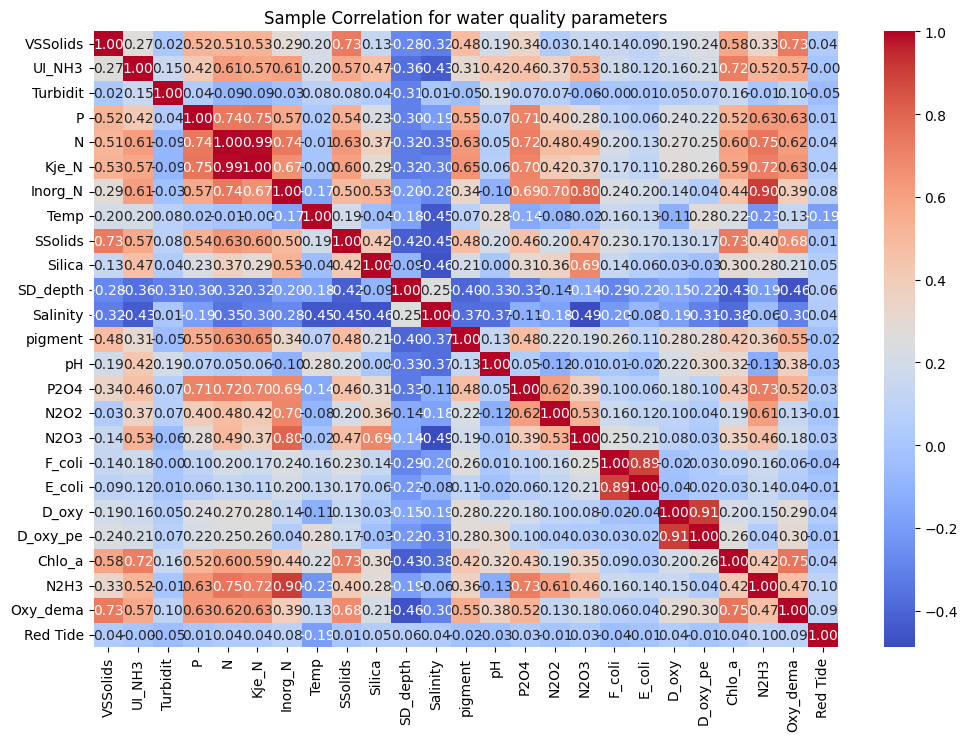

In [87]:
import seaborn as sb
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = zone_data.drop(columns=['Date']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Sample Correlation for water quality parameters")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_3928\2149178071.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  average_data = pd.concat(station_data.values(), axis=1).groupby(level=0, axis=1).mean()


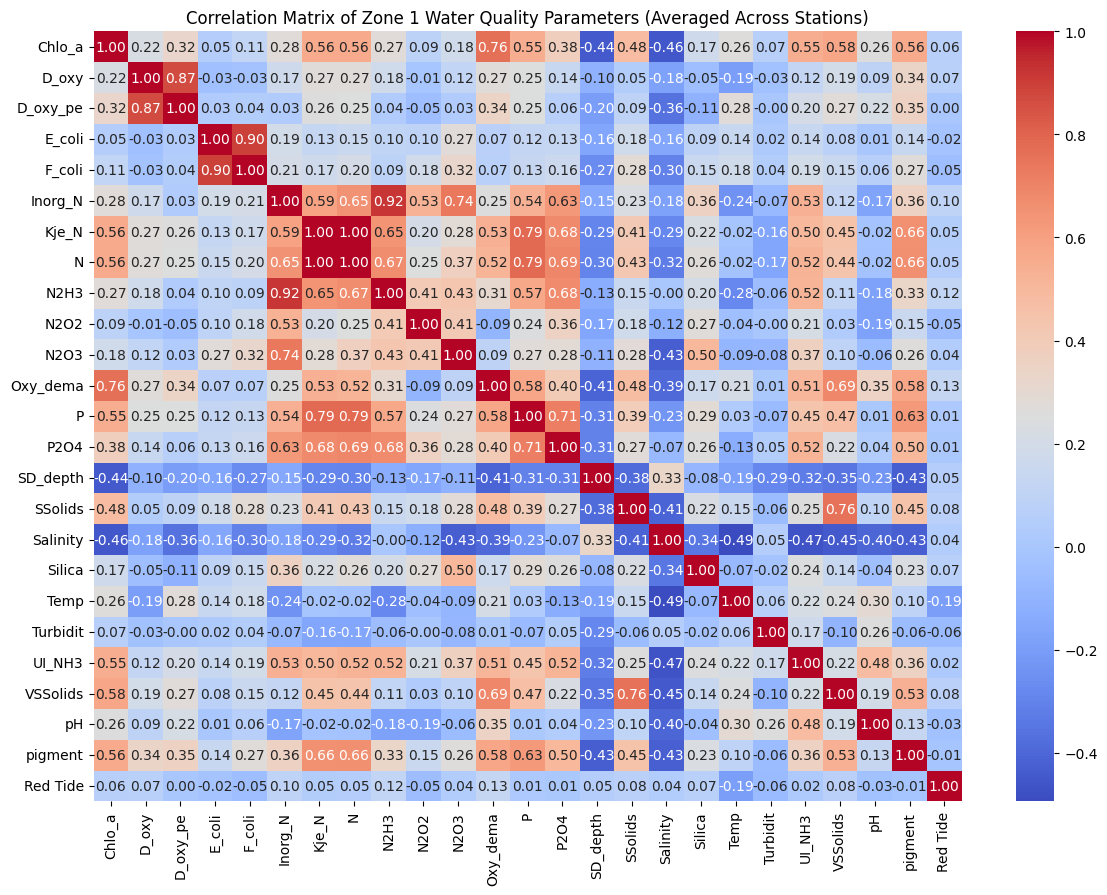

In [96]:
import pandas as pd
import numpy as np

# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1
zone1_columns = ['Date'] + [col for col in dailydata.columns if col.startswith('Zone1_TM')]
zone1_data = dailydata[zone1_columns].copy()

# Group the Zone1 data by station (TM3, TM4, TM6, TM8)
stations = ['TM3', 'TM4', 'TM6', 'TM8']
station_data = {station: zone1_data.filter(like=f'Zone1_{station}', axis=1) for station in stations}

# Rename columns to remove station identifiers and the 'Sur_' prefix
for station in stations:
    station_data[station].columns = [
        col.replace(f'Zone1_{station}_', '').replace('Sur_', '') for col in station_data[station].columns
    ]

# Compute the average of the four stations
average_data = pd.concat(station_data.values(), axis=1).groupby(level=0, axis=1).mean()

# Add the 'Date' and 'Red Tide' columns back to the dataset
average_data['Date'] = zone1_data['Date']
average_data = average_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
average_data['Red Tide'] = average_data['Red Tide'].fillna(0).astype(int)

# Drop 'Date' column to calculate correlation matrix
correlation_matrix = average_data.drop(columns=['Date']).corr()

# Plot the correlation heatmap
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Sample Correlation Matrix of Water Quality Parameters")
plt.show()


SeaTemperature             0.082812
Rainfall                   0.082500
MeanRelativeHumidity       0.064467
DewPointTemp               0.061923
GrassMinimunTemperature    0.057674
WebBulbTemp                0.057103
MinTemp                    0.053827
MeanAmountCloud            0.052545
MeanTemp                   0.051094
MaxTemp                    0.036715
PrevailingWindDirection    0.034550
Evaporation               -0.020975
Pressure                  -0.021698
BrightSunshine            -0.055616
GlobalSolarRadiation      -0.057785
WindSpeed                 -0.062222
ReducedVisibility         -0.131891
Name: Red Tide, dtype: float64


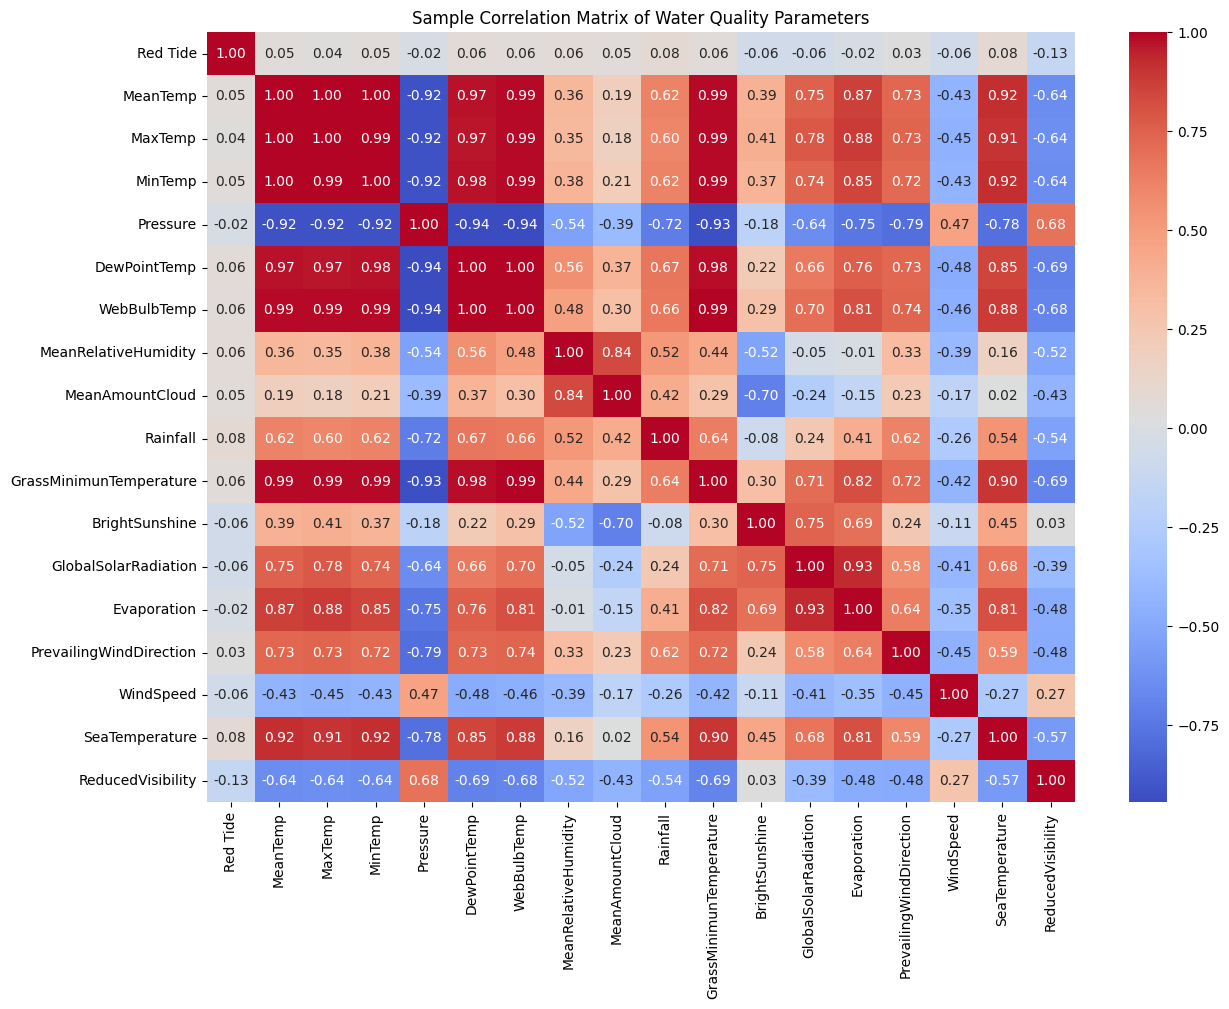

In [1]:
import pandas as pd
import numpy as np

# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
climate_data = pd.read_csv('climate.csv')

# Convert 'Date' columns to datetime format
climate_data['Date'] = pd.to_datetime(climate_data['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Filter only rows with valid dates
rt = rt.dropna(subset=['Date'])
climate_data = climate_data.dropna(subset=['Date'])

# Keep only common dates
common_dates = set(rt['Date']).intersection(set(climate_data['Date']))
rt_filtered = rt[rt['Date'].isin(common_dates)]
climate_filtered = climate_data[climate_data['Date'].isin(common_dates)]

# Merge datasets on 'Date'
merged_data = pd.merge(rt_filtered, climate_filtered, on='Date')

# Calculate correlations
correlation_matrix = merged_data.drop(columns=['Date']).corr()

# Extract correlations of 'Red Tide' with climate parameters
red_tide_correlations = correlation_matrix['Red Tide'][climate_data.columns.difference(['Date'])]

# Display results
print(red_tide_correlations.sort_values(ascending=False))

# Plot the correlation heatmap
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Sample Correlation Matrix of Water Quality Parameters")
plt.show()

First 5 rows of the dataset:


,Date,Zone1_TM3_Sur_VSSolids,Zone1_TM3_Sur_UI_NH3,Zone1_TM3_Sur_Turbidit,Zone1_TM3_Sur_P,Zone1_TM3_Sur_N,Zone1_TM3_Sur_Kje_N,Zone1_TM3_Sur_Inorg_N,Zone1_TM3_Sur_Temp,Zone1_TM3_Sur_SSolids,...,Zone10_VM7_Sur_P2O4,Zone10_VM7_Sur_N2O2,Zone10_VM7_Sur_N2O3,Zone10_VM7_Sur_F_coli,Zone10_VM7_Sur_E_coli,Zone10_VM7_Sur_D_oxy,Zone10_VM7_Sur_D_oxy_pe,Zone10_VM7_Sur_Chlo_a,Zone10_VM7_Sur_N2H3,Zone10_VM7_Sur_Oxy_dema
0,1997-01-01,2.314286,0.012857,2.333333,0.199524,0.969524,0.928571,0.222381,19.085714,3.523810,...,0.065000,0.025067,0.112267,5973.333333,2480.000000,6.080000,78.666667,1.026667,0.324667,0.693333
1,1997-01-02,2.289401,0.013235,2.313364,0.198111,0.999816,0.956682,0.227696,19.041014,3.495392,...,0.064709,0.025097,0.111641,5951.228878,2501.766513,6.067051,78.450845,1.016129,0.323994,0.694240
2,1997-01-03,2.264516,0.013613,2.293395,0.196697,1.030108,0.984793,0.233011,18.996313,3.466974,...,0.064418,0.025127,0.111014,5929.124424,2523.533026,6.054101,78.235023,1.005591,0.323321,0.695146
3,1997-01-04,2.239631,0.013991,2.273425,0.195284,1.060399,1.012903,0.238326,18.951613,3.438556,...,0.064127,0.025157,0.110388,5907.019969,2545.299539,6.041152,78.019201,0.995054,0.322648,0.696052
4,1997-01-05,2.214747,0.014369,2.253456,0.193871,1.090691,1.041014,0.243641,18.906912,3.410138,...,0.063836,0.025187,0.109762,5884.915514,2567.066052,6.028203,77.803379,0.984516,0.321975,0.696959



Summary Statistics:


,Date,Zone1_TM3_Sur_VSSolids,Zone1_TM3_Sur_UI_NH3,Zone1_TM3_Sur_Turbidit,Zone1_TM3_Sur_P,Zone1_TM3_Sur_N,Zone1_TM3_Sur_Kje_N,Zone1_TM3_Sur_Inorg_N,Zone1_TM3_Sur_Temp,Zone1_TM3_Sur_SSolids,...,Zone10_VM7_Sur_P2O4,Zone10_VM7_Sur_N2O2,Zone10_VM7_Sur_N2O3,Zone10_VM7_Sur_F_coli,Zone10_VM7_Sur_E_coli,Zone10_VM7_Sur_D_oxy,Zone10_VM7_Sur_D_oxy_pe,Zone10_VM7_Sur_Chlo_a,Zone10_VM7_Sur_N2H3,Zone10_VM7_Sur_Oxy_dema
count,7275,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,...,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000
mean,2006-12-17 00:00:00,1.737449,0.005507,5.359348,0.041844,0.455771,0.423039,0.105100,24.448331,2.733691,...,0.034613,0.033907,0.170303,16293.087576,6735.531474,5.566485,77.813983,3.675262,0.216019,1.063969
min,1997-01-01 00:00:00,0.500000,0.001000,0.364865,0.020000,0.178286,0.175143,0.016429,15.625000,0.800000,...,0.002000,0.005000,0.049125,80.909091,24.545455,3.100000,47.375000,0.200000,0.025625,0.121429
25%,2001-12-24 12:00:00,1.204362,0.002235,2.494264,0.024334,0.279839,0.259945,0.049664,20.510379,1.804206,...,0.025891,0.021267,0.104831,4493.309976,2039.753577,4.959867,70.277220,1.104005,0.163231,0.781928
50%,2006-12-17 00:00:00,1.598668,0.003776,4.989867,0.031054,0.333439,0.310971,0.077047,25.401267,2.424435,...,0.035511,0.029854,0.140191,10019.600000,4574.423963,5.511613,75.840934,1.911521,0.213404,0.951471
75%,2011-12-09 12:00:00,2.108844,0.006643,7.358843,0.046459,0.459343,0.423326,0.124533,28.315095,3.203735,...,0.042647,0.043111,0.212844,21205.821363,10014.225348,6.073102,83.530751,4.048669,0.268583,1.248431
max,2016-12-01 00:00:00,6.944444,0.084143,36.000000,0.300000,2.666667,2.500000,0.828889,31.117647,10.788571,...,0.073259,0.107300,0.734091,202221.818200,51021.818180,9.477273,134.318182,26.357143,0.410833,5.055556
std,NaN,0.796204,0.006806,3.738464,0.031521,0.325611,0.304004,0.094862,4.195278,1.331496,...,0.013102,0.016277,0.091664,19580.641098,6558.723863,0.898848,11.708304,4.492563,0.078717,0.496553


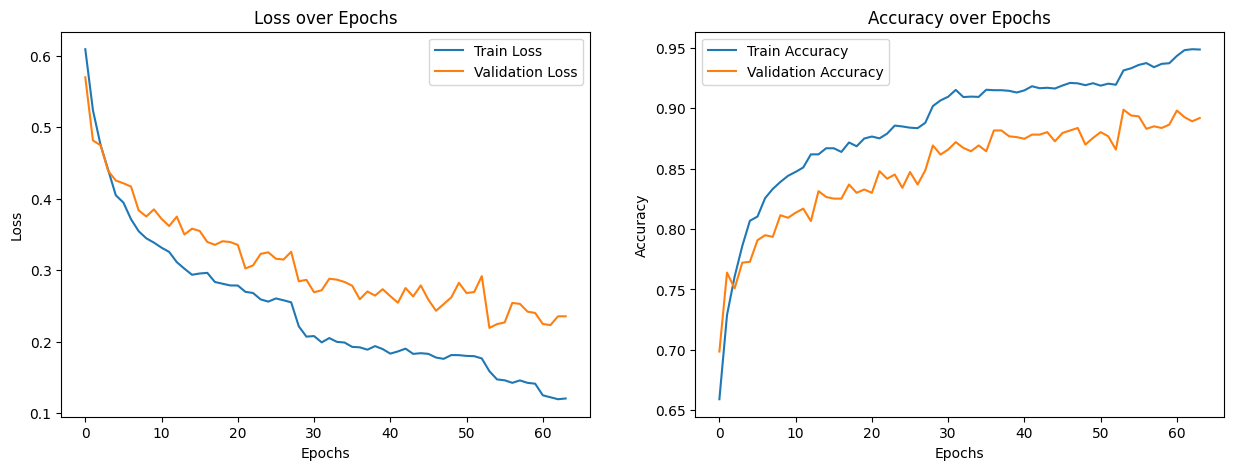

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact, widgets
import plotly.graph_objects as go
from tensorflow.keras.models import load_model

# Load data and model
zone_data = pd.read_csv('c.csv')  # Replace with cleaned data file path
zone_data['Date'] = pd.to_datetime(zone_data['Date'], errors='coerce')
model = load_model('red_tide_bilstm_model.keras')

# Initialize a scaler (ensure it's the same used during training)
scaler = StandardScaler()

# Helper functions
def plot_training_history(history):
    """Plot training loss and accuracy."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Plot
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy Plot
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Accuracy over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.show()

def display_metrics(y_true, y_pred, y_pred_prob):
    """Display classification metrics."""
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("AUC Score:", roc_auc_score(y_true, y_pred_prob))

def plot_confusion_matrix(cm):
    """Plot confusion matrix."""
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def create_dataset(X, y, time_steps=14):
    """Create time-series sequences."""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Model Evaluation
def evaluate_model():
    """Evaluate model and visualize metrics."""
    # Load test data
    X_test = pd.read_csv(r"C:\Users\User\FYP(DESKTOP)\val set\zone1_daily.csv")  # Replace with actual file paths
    y_test = pd.read_csv(r"C:\Users\User\FYP(DESKTOP)\val set\red_tide_val.csv")
    
    # Convert 'Date' columns to datetime format
    X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')

    # Preprocess and select features
    # Assuming you already cleaned and processed the data
    # Select relevant features based on zone and parameters
    zone_params = ['Date'] + [
        col for col in X_test.columns
        if 'Zone1' in col and re.search(r'(Sur_N|Sur_Chlo_a|Sur_P|Sur_Temp|Sur_Turbidit|Sur_D_oxy)(?=$|_)', col) and 'Zone10' not in col
    ]
    X_test = X_test[zone_params].copy()

    # Ensure scaling (use the scaler fitted during training)
    X_test_scaled = scaler.transform(X_test.drop('Date', axis=1))  # Ensure 'Date' column is excluded

    # Create sequences
    X_test_seq, y_test_seq = create_dataset(X_test_scaled, y_test.values.flatten(), time_steps=14)

    # Predict
    y_pred_prob = model.predict(X_test_seq)
    y_pred_classes = (y_pred_prob > 0.5).astype(int)
    
    # Display metrics
    display_metrics(y_test_seq, y_pred_classes, y_pred_prob)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test_seq, y_pred_classes)
    plot_confusion_matrix(cm)

# Interactive Prediction
def predict_new(data_input):
    """Predict red tide occurrence for new data."""
    data_scaled = scaler.transform([data_input])
    time_steps = 14
    data_seq = np.expand_dims(data_scaled, axis=0)  # Ensure proper shape for prediction
    pred_prob = model.predict(data_seq)
    pred_class = (pred_prob > 0.5).astype(int)
    return f"Predicted Class: {pred_class[0][0]}, Probability: {pred_prob[0][0]:.2f}"

# Build Dashboard Interface
def display_dashboard():
    """Create a dashboard interface."""
    tab = widgets.Tab()
    tab.children = [
        widgets.Output(),  # Data Overview
        widgets.Output(),  # Training Visualization
        widgets.Output(),  # Model Evaluation
        widgets.Output()   # Prediction Interface
    ]
    tab.set_title(0, "Data Overview")
    tab.set_title(1, "Training Visualization")
    tab.set_title(2, "Model Evaluation")
    tab.set_title(3, "Prediction Interface")

    # Fill tabs with content
    with tab.children[0]:
        with widgets.Output():
            print("First 5 rows of the dataset:")
            display(zone_data.head())
            print("\nSummary Statistics:")
            display(zone_data.describe())

    with tab.children[1]:
        plot_training_history(history)  # Ensure `history` is loaded correctly

    with tab.children[2]:
        evaluate_model()

    with tab.children[3]:
        data_input = widgets.Textarea(
            description='Input Data:',
            placeholder='Enter comma-separated feature values...',
            layout=widgets.Layout(width='400px', height='50px')
        )
        predict_button = widgets.Button(description="Predict")
        output = widgets.Output()
        
        def on_predict_button_clicked(b):
            with output:
                output.clear_output()
                input_data = list(map(float, data_input.value.split(',')))
                prediction = predict_new(input_data)
                print(prediction)
        
        predict_button.on_click(on_predict_button_clicked)
        display(widgets.VBox([data_input, predict_button, output]))

    return tab

# Display the dashboard
dashboard = display_dashboard()
dashboard
